# 0) Main objective

The project is about employing unsupervised learning techniques for data clustering.

# 1) Setup environment

In [1]:
%%capture --no-display
!pip install pandas scikit-learn seaborn nltk wordcloud umap-learn numpy==1.24.0

In [2]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet
from sklearn.cluster import HDBSCAN
from matplotlib.lines import Line2D

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/guillaume/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Impose a seed for reproducibility
random_seed = 421

# 2) Dataset

## 2.A) Dataset description

We use the publicly available `20 Newsgroup` dataset. The dataset is a collection of text documents taken from different online communities on Internet forums and newsgroups. The original dataset contains 20 different sub-categories, organized within six main categories, amounting to approximately 18,000 entries. To simplifiy the problem, we will only select six sub-categories, that is, one sub-category for each of the six main categories, amounting to 5,706 entries.

In [5]:
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=random_seed,
    categories=['misc.forsale', 'soc.religion.christian', 'comp.graphics', 'talk.politics.misc', 'sci.space', 'rec.sport.hockey'],
)

In [6]:
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: dataset.target_names[x])


from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
df['label_indices'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,label_indices
0,\nNo one is questioning whether Mr. King is bl...,talk.politics.misc,5
1,"\n\nWhatever you do, don't FTP to the sites li...",comp.graphics,0
2,\nIt was Clint Malarchuk's neck cut by Uwe Kru...,rec.sport.hockey,2
3,\n\nWow. So that's probably the reason why cu...,rec.sport.hockey,2
4,\nThe front covers should be available from So...,misc.forsale,1


In [7]:
unique_labels = np.unique(df['label'])
number_of_unique_labels = len(unique_labels)
number_of_samples = len(df['text'])
print('There are {} different labels that describe a total of {} documents.'.format(
    number_of_unique_labels, number_of_samples))

There are 6 different labels that describe a total of 5706 documents.


The different labels are the following. We note that the distribution is not uniform, there is a slight class imbalance.

0: comp.graphics
1: misc.forsale
2: rec.sport.hockey
3: sci.space
4: soc.religion.christian
5: talk.politics.misc


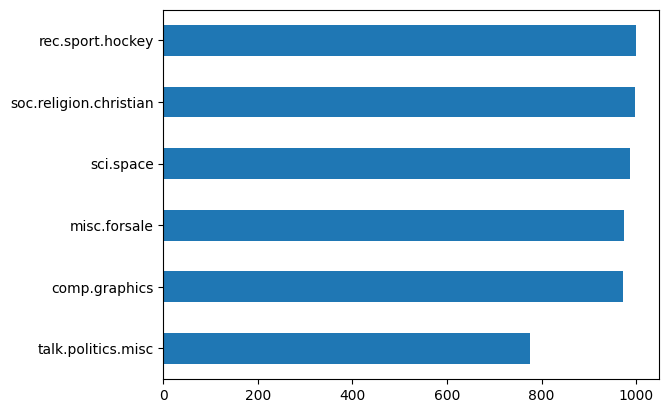

In [8]:
for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))
    
df.label.value_counts().plot.barh()
plt.gca().invert_yaxis()

Below we provide an example of raw samples taken from all different labels:

In [9]:
# Example entry from "comp.graphics"
index=9
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 9 (label: comp.graphics)
----------------------------------------------------------------

Hello,

    I have been searching for a quality image enhancement and
    manipulation package for Unix/X/Motif platforms that is comparable
    to Adobe Photo Shop for the Mac.

    I have not been able to find any, and would appreciate any
    information about such products you could provide.

    I would be particularly interested in software that runs on HP or
    Sun workstations, and does not require special add-in hardware, but
    would also be interested in other solutions.


Thank You.
Wayne



In [10]:
# Example entry from "soc.religion.christian"
index=37
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 37 (label: soc.religion.christian)
----------------------------------------------------------------

Over the years, I have met Christians who are not associated with
any local church and are not members of any local church. This is
an issue that may be very personal, but is important.  What does
the Bible say about this and how can we encourage our friends with
regard to this issue?



In [11]:
# Example entry from "soc.religion.christian"
index=81
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 81 (label: talk.politics.misc)
----------------------------------------------------------------

->     >Now let me get this straight. After a nice, long rant about
->     >how people need to take personal responsibility for their
->     >economic and social lives, all of a sudden 1960's radicals
->     >(such as me, I guess) are responsible for poor people's
->     >lifestyles? Tell me how that works--or do you think that poor
->     >people are just too dumb to think for themselves?
->     >
->     >There are many reasons for the disintegration of the family
->     >and support systems in general among this nation's poor.
->     >Somehow I don't think Murphy Brown--or Janis Joplin--is at
->     >the top of any sane person's list.
->     >
->     >You want to go after my generation's vaunted cultural
->     >revolution for a lasting change for the worse, try so-called
->     >"relevant" or "values" education. Hey, it seemed like a good
->     >idea at the time. 

In [12]:
# Example entry from "rec.sport.hockey"
index=86
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 86 (label: rec.sport.hockey)
----------------------------------------------------------------



Ah yes.  California.  Did the San Francisco Bay area media report that
Joe Montana is rumoured to be the leading candidate to replace fired
San Jose Sharks coach George Kingston?  Apparently Montana is not only
coveted for his winning attitude, but as a playing coach he will be
expected to quarterback the powerplay.

Good thing those walls are so soft, eh Rollie?


-- 



In [13]:
# Example entry from "misc.forsales"
index=88
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 88 (label: misc.forsale)
----------------------------------------------------------------

SOMEONE PLEASE BUY THESE BOOKS!!!!!  I AM NOT ASKING MUCH!!!!!!

LIQUIDATION!!!!!! Send me your offer!  No reasonable offer refused!
First come first served! I JUST WANT TO GET RID OF THESE BOOKS!!!
JUST MAKE ME AN OFFER!!!!!  

* Calculus w/ Analytic Geometry by Authur B. Simon (copyright date 1982), below avg condition but still readable!  Give me $8 (shipping incl) and its yours!

* Writing good software in Fortran, Graham Smith.  $12 (shipp incl) 

* General Chemistry Principles & Modern Applications, R. Petrucci, fourth
  edition.  Big Book! (this book + following 2 books $20 for all 3!!)

* Solutions manual for Chemistry book. 

* Study guide for Chemistry book. 


Send me your offers via email at 02106@chopin.udel.edu





In [14]:
# Example entry from "sci.space"
index=146
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 146 (label: sci.space)
----------------------------------------------------------------


Alan,

	don't forget,  a HUGE  cost for airliner developement is FAA
certification.  the joke is when the paperwork  exceeds teh weight
of the airplane,  it will fly.

The SR-71, and teh X-15  both highly ambitious  aero-space projects were done
on very narrow engineering budgets.   Partly because they didn't spend much
on paper  pushing.   There is some company in missouri  trying to
get funding to build light commercial transporters  on a low cost basis,
mostly by reducing FAA  certification costs.



## 2.B) Systematic cleaning

The data is corrupted by several factors that decrease semantic value and prevent effective clustering, such as for instance the presence of special characters (e.g., `!`, `<`, `#`) and common words (e.g., `and`, `me`, `the`). We will apply a first cleansing phase to better prepare the clustering.

In [15]:
# Remove HTML tages (everything within the "<>" brackets")
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
df['text'] = df['text'].apply(remove_html_tags)

In [16]:
# Keep only alphabetical characters (26 roman letters)
def keep_only_alphas(text):
    return ' '.join(re.findall("[a-zA-Z]+", text))
df['text'] = df['text'].apply(keep_only_alphas)

In [17]:
# Set to lowercase
def set_to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(set_to_lowercase)

In [18]:
# Remove most common words ("it", "your", "as", etc.) as they are void of informational content for clustering
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [19]:
# Remove short words that are only one or two letters long (note that the subsequent Lemmatization may re-create words shorter than 2 letters)
def remove_short_words(text):
    length_threshold = 2
    return ' '.join(word for word in text.split() if len(word)>length_threshold)
df['text'] = df['text'].apply(remove_short_words)

In [20]:
# Lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def apply_lemmatization(text):
    word_tokens = word_tokenize(text)    
    pos_tags = pos_tag(word_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word_tokens, get_wordnet_pos(tag)) for word_tokens, tag in pos_tags]
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(apply_lemmatization)    

## 2.C) Tailored cleaning

We will observe the most common words and take the decision to remove these which do not bring intrinsic meaning to further assist the clusterization task.

In [21]:
# We print the 200 most common words of the entire dataset
count = Counter(w for x in df['text'] for w in x.split())
most_commons = count.most_common(200)
print(most_commons)

[('would', 3526), ('one', 3339), ('get', 2746), ('use', 2549), ('say', 2511), ('make', 2416), ('know', 2397), ('think', 2342), ('people', 2129), ('like', 2106), ('time', 2020), ('god', 2008), ('image', 1959), ('also', 1939), ('well', 1709), ('new', 1696), ('see', 1691), ('year', 1645), ('good', 1584), ('work', 1532), ('space', 1511), ('game', 1498), ('come', 1456), ('take', 1422), ('go', 1414), ('system', 1346), ('want', 1318), ('first', 1316), ('give', 1313), ('may', 1312), ('could', 1267), ('program', 1265), ('look', 1263), ('thing', 1259), ('point', 1247), ('edu', 1243), ('way', 1227), ('need', 1207), ('even', 1206), ('file', 1203), ('two', 1178), ('much', 1167), ('find', 1159), ('include', 1147), ('many', 1111), ('believe', 1090), ('right', 1070), ('call', 1061), ('question', 1003), ('graphic', 957), ('team', 953), ('please', 946), ('mean', 943), ('post', 928), ('try', 926), ('play', 901), ('ask', 891), ('mail', 848), ('problem', 845), ('christian', 842), ('data', 833), ('back', 82

In [22]:
# We identify and remove words that do not carry a semantically meaningful information for clustering
extra_stop_words = ['would', 'one', 'get', 'also', 'could', 'may', 'two', 'much', 'many', 'going', 'three']
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (extra_stop_words)]))

## 2.D) Visualization of the cleansed dataset

Below we provide the cleansed version of the same examples from all six labels:

In [23]:
# Example entry from "soc.religion.christian"
index=37
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 37 (label: soc.religion.christian)
----------------------------------------------------------------

year meet christian associate local church member local church issue personal important bible say encourage friend regard issue



In [24]:
# Example entry from "soc.religion.christian"
index=81
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 81 (label: talk.politics.misc)
----------------------------------------------------------------

let straight nice long rant people need take personal responsibility economic social life sudden radical guess responsible poor people lifestyle tell work think poor people dumb think reason disintegration family support system general among nation poor somehow think murphy brown janis joplin top sane person list want generation vaunt cultural revolution last change bad try call relevant value education hey seem like good idea time know need real education first mean take grant generation spoil irresponsible depression create mother father determine kid want anything go overboard create nation brat consider contrast famous event july apollo woodstock group large number people fee reverted cultural level primitive defecation public etc group assemble take care dispersed damage death large number drug problem woodstock call big parking lot history reject society go back

In [25]:
# Example entry from "rec.sport.hockey"
index=86
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 86 (label: rec.sport.hockey)
----------------------------------------------------------------

yes california san francisco bay area medium report joe montana rumour leading candidate replace fire san jose shark coach george kingston apparently montana coveted win attitude play coach expect quarterback powerplay good thing wall soft rollie



In [26]:
# Example entry from "misc.forsales"
index=88
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 88 (label: misc.forsale)
----------------------------------------------------------------

someone please buy book ask liquidation send offer reasonable offer refuse first come first serve want rid book make offer calculus analytic geometry authur simon copyright date avg condition still readable give shipping incl write good software fortran graham smith shipp incl general chemistry principle modern application petrucci fourth edition big book book follow book solution manual chemistry book study guide chemistry book send offer via email chopin udel edu



In [27]:
# Example entry from "sci.space"
index=146
print('Example: sample number {} (label: {})\n{}\n\n{}\n'.format(
    index, df.label[index], '-' * 64, df.text[index]))

Example: sample number 146 (label: sci.space)
----------------------------------------------------------------

alan forget huge cost airliner developement faa certification joke paperwork exceed teh weight airplane fly teh highly ambitious aero space project do narrow engineering budget partly spend paper push company missouri try funding build light commercial transporter low cost basis mostly reduce faa certification cost



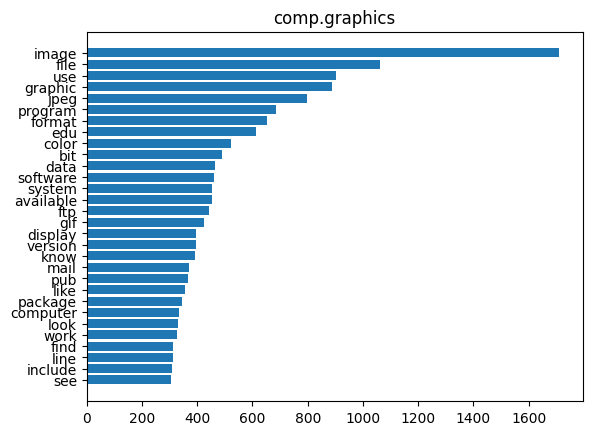

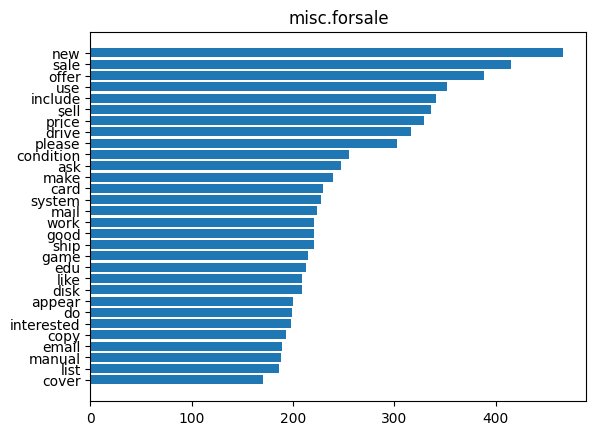

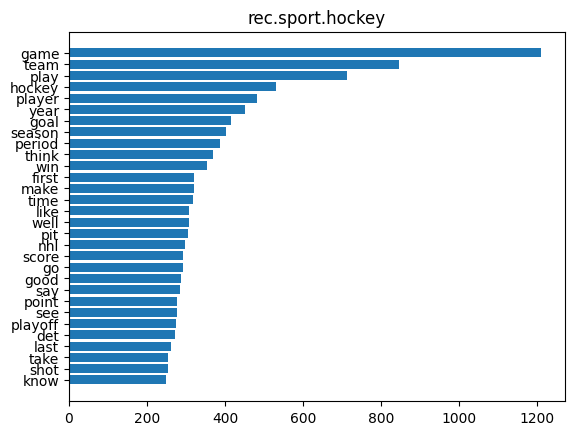

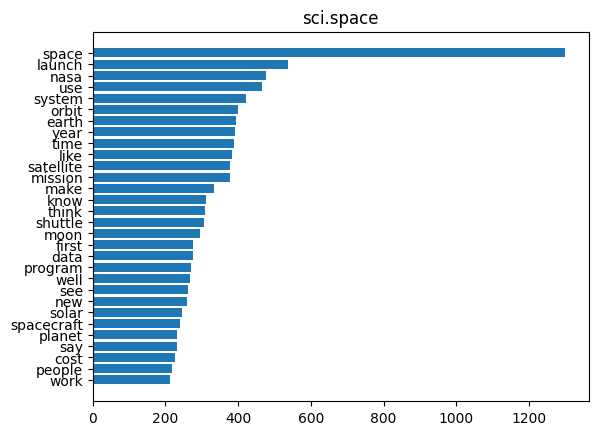

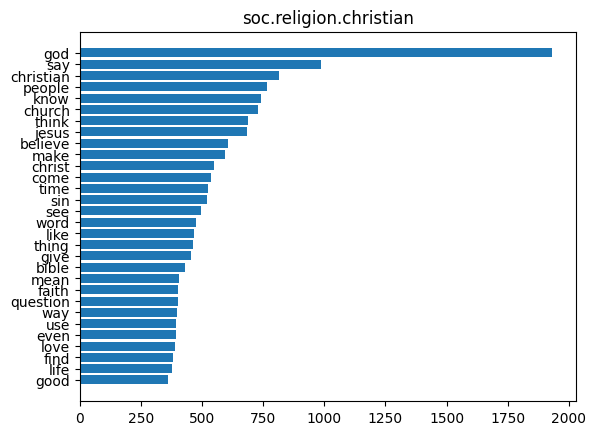

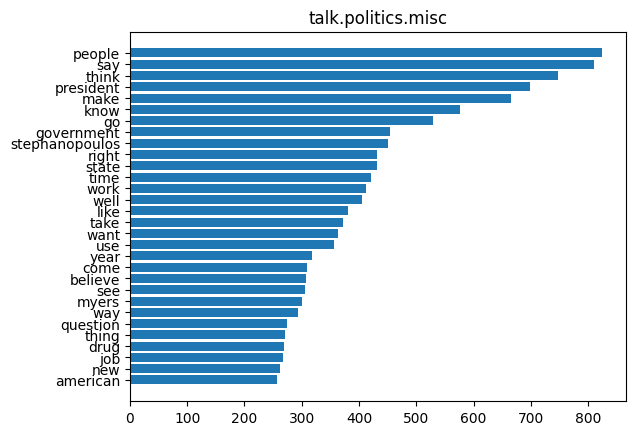

In [28]:
# We display the most common 30 words for each label. We observe that a strong semantic association emmerges between the label of each newsgroup and the most common words.
for label_index in range(number_of_unique_labels):
    label = unique_labels[label_index]
    
    df_single = df[df['label'].isin({label})]
    count = Counter(w for x in df_single['text'] for w in x.split())
    most_commons = count.most_common(30)

    plt.figure()
    plt.barh(*zip(*most_commons));
    plt.gca().invert_yaxis()
    plt.title(label)

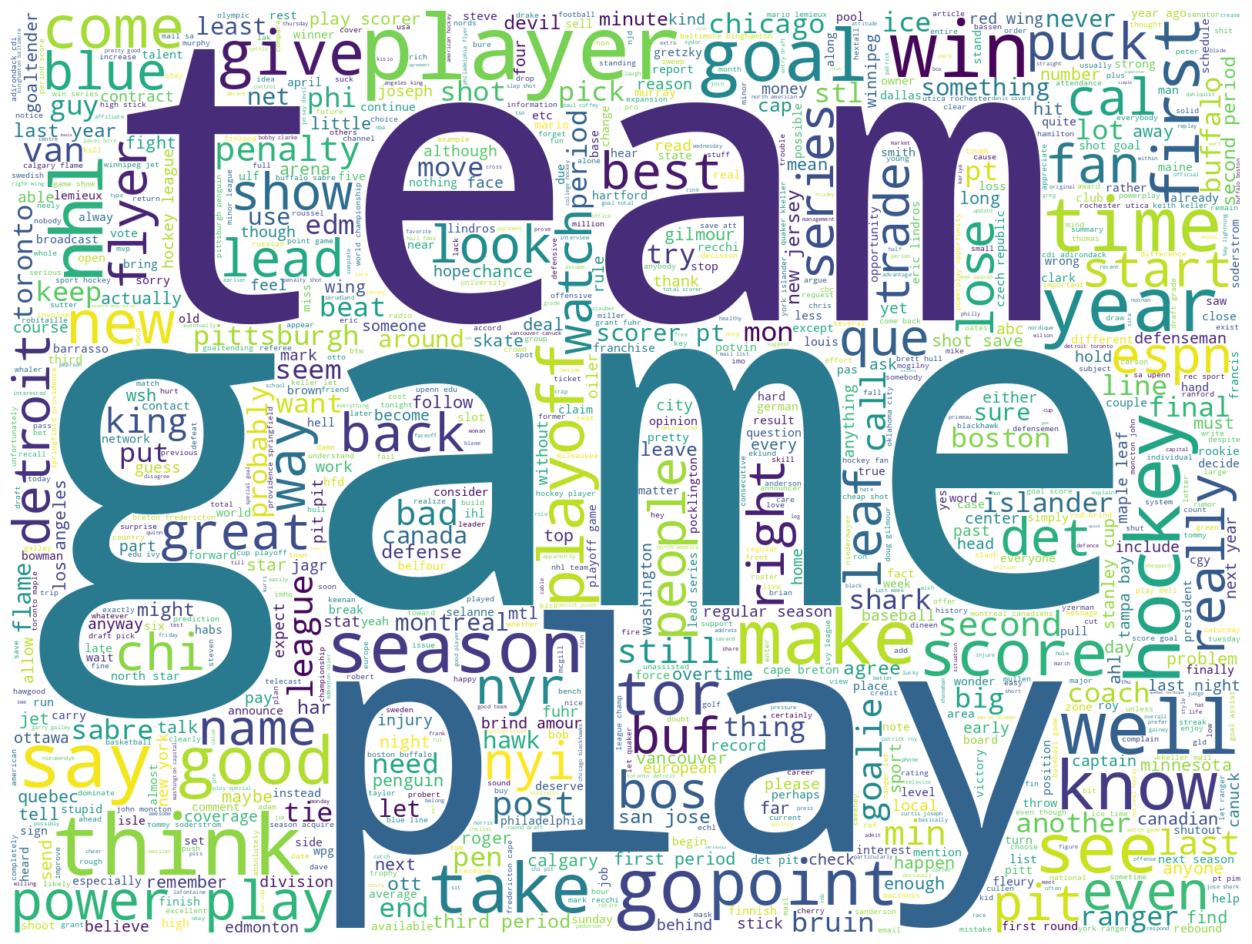

In [29]:
# Alternative representation of the most common words, for the label 'rec.sport.hockey' 
wordcloud = WordCloud(background_color="white", max_words=1000, random_state = random_seed, width=1600, height=1200)
df_hockey = df[df['label'].isin({'rec.sport.hockey'})]
df_hockey = df_hockey.text.tolist()
df_hockey = ' '.join(df_hockey)
wordcloud.generate(df_hockey)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 3) Clustering

## 3.A) Vectorization

We start by applying an operation to transform each sample in a N-dimensional vector, based on the words (tokens) that constitute the sample.

In [30]:
vectorizer = TfidfVectorizer(min_df=3)
vectors = vectorizer.fit_transform(df['text'])
tokens = vectorizer.get_feature_names_out()

print('Number of entries: {}'.format(vectors.shape[0]))
print('Number of dimensions: {}'.format(vectors.shape[1]))
print('Percentage of non-zero entries: {:.3f}%'.format(100 * vectors.nnz / (vectors.shape[0] * vectors.shape[0])))
print('Example of 100 random tokens: {}'.format(tokens[np.random.permutation(vectors.shape[1])[:100]]))

Number of entries: 5706
Number of dimensions: 13104
Percentage of non-zero entries: 1.037%
Example of 100 random tokens: ['elvis' 'modular' 'mood' 'afraid' 'wage' 'intention' 'elitserien'
 'dialect' 'falsely' 'greeks' 'accustom' 'outlet' 'bend' 'macinnis' 'cpus'
 'meteorology' 'sega' 'corinthian' 'martyr' 'coleco' 'shard' 'documentary'
 'gallant' 'amigajpegv' 'sysop' 'hurl' 'income' 'xmgr' 'compatable'
 'verdict' 'rev' 'bomber' 'hurdle' 'predominantly' 'forte' 'heretic' 'psu'
 'whatsoever' 'adg' 'llo' 'derrill' 'toilet' 'vaticanus' 'vco' 'reliable'
 'propensity' 'paid' 'fuhr' 'allegiance' 'brentb' 'handmade' 'devils'
 'votenooct' 'macs' 'sexless' 'foreseeable' 'uncompromising' 'decrease'
 'cosmological' 'grown' 'infinitely' 'clp' 'stuff' 'hierachical'
 'enthusiastic' 'costa' 'importantly' 'blood' 'aero' 'psc' 'bead' 'dafoe'
 'naplps' 'trip' 'cunningham' 'relative' 'venus' 'cory' 'scivi' 'sony'
 'sci' 'damphousse' 'scary' 'famine' 'unizh' 'courtesy' 'mining'
 'concession' 'dd' 'dragon' 

## 3.B) Principal Components Analysis (PCA)

We apply a first unsupervised clustering approach to the dataset with PCA.

In [31]:
n_components = 1000
pca = PCA(n_components=n_components, random_state=random_seed)

In [32]:
pca_components = pca.fit_transform(vectors)

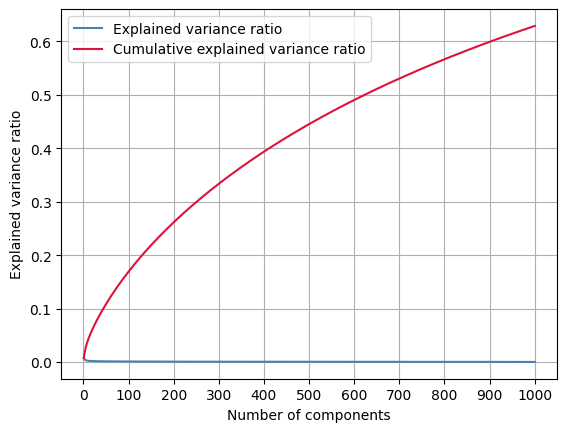

In [33]:
plt.figure()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_, color='steelblue', label='Explained variance ratio')
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), color='crimson', label='Cumulative explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.xticks(range(0, n_components+1, 100))
plt.legend()
plt.grid()
plt.show()

We observe that a great number of features is required to adequately describe the dataset. The figure above shows that with a combination of 1000 features, we can only explain about 62% of the variance. Below, we plot 2D representations of several pairs of components. We observe that the clustering operation is quite sub-optimal because the different clusters overlap in a certain extent. We also verify that the first components (here 0-3) are the most effective at separating clusters, while more medium-valued components (here 10-13) afford a much coarser clusterization, and high-valued components (here >100) do not contribute significantly to the clusterization.

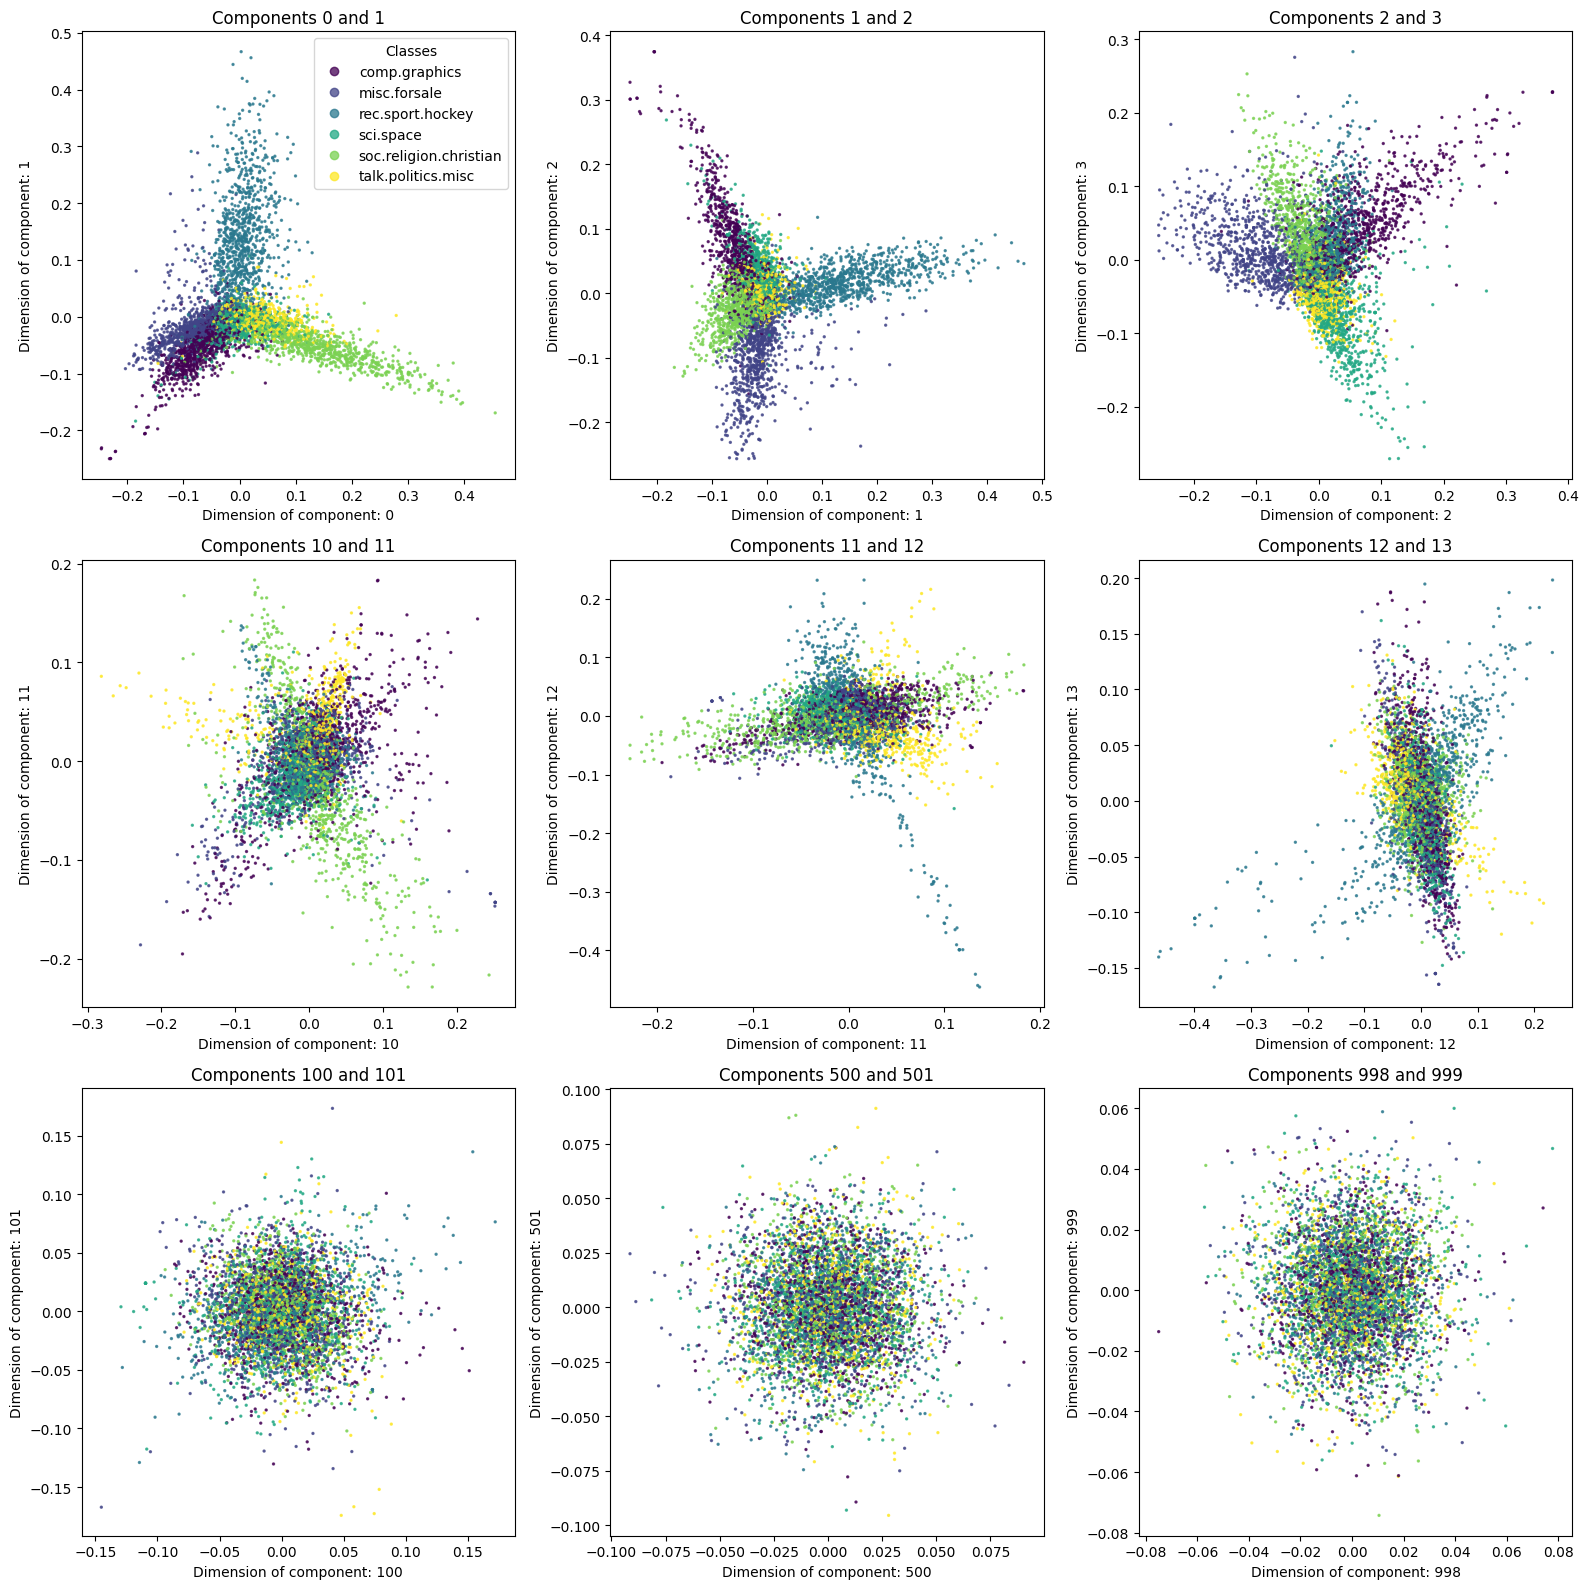

In [34]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(16, 16, forward=True)
ax = ax.ravel()
c1 = np.asarray([0, 1, 2, 10, 11, 12, 100, 500, 998])
c2 = np.asarray([1, 2, 3, 11, 12, 13, 101, 501, 999])
for subplot_index in range(9):
    axx = ax[[subplot_index]]
    fig.sca(axx)
    scatter = plt.scatter(pca_components[:,c1[subplot_index]], pca_components[:,c2[subplot_index]], c=df['label_indices'], alpha=0.75, s=2)
    plt.xlabel('Dimension of component: {}'.format(c1[subplot_index]))
    plt.ylabel('Dimension of component: {}'.format(c2[subplot_index]))
    plt.title('Components {} and {}'.format(c1[subplot_index], c2[subplot_index]))
    if subplot_index == 0:
        plt.legend(scatter.legend_elements()[0], unique_labels, loc='upper right', title='Classes')
plt.tight_layout()
plt.show()

## 3.C) KMeans

We apply a second unsupervised clustering approach to the dataset with KMeans.

In [35]:
# We define the transformation object
km = KMeans(n_clusters=number_of_unique_labels, init='k-means++', max_iter=700, n_init=200, random_state=random_seed)

In [36]:
# We apply the object to the data
km.fit(vectors)

KMeans(max_iter=700, n_clusters=6, n_init=200, random_state=421)

In [37]:
# We print the tokens that correspond to the 20 strongest constituents of each of the six estimated clusters
centroids = km.cluster_centers_.argsort()[:,::-1]
for cluster_index in range(number_of_unique_labels):
    print('Cluster {}, {} points'.format(cluster_index, np.sum(km.labels_ == cluster_index)))
    for centroid_index in centroids[cluster_index, :20]:
        print('{} '.format(tokens[centroid_index]), end='')
    print('\n')

Cluster 0, 2808 points
people say think like know make use time want see right year well good go look state new post even 

Cluster 1, 596 points
god christian jesus church say sin christ believe people faith bible know think thing life love make christianity come word 

Cluster 2, 644 points
file image graphic thanks program format anyone know please use look ftp bit mail help color gif code convert software 

Cluster 3, 662 points
game team play hockey player playoff win espn season year goal nhl fan score think last see pen well good 

Cluster 4, 369 points
space launch orbit shuttle nasa mission satellite moon cost earth use think system like hst lunar station year program solar 

Cluster 5, 627 points
sale offer drive sell condition price new include please manual interested card ship disk email ask use mail meg edu 



From the results above, the label of `Clusters 1-5` can be very easily attributed. However, it appears that `Cluster 0` comprises significantly more points that each other individual cluster (about 4 to 7 times more), and contains tokens with semantic meaning that does not seem to strongly match the remaining topic (`talk.politics.misc`). This may be attributed to the fact that the political discussions can generally cover a broader scope.

We can re-organize the Cluster ordering in the following fashion:
- Cluster 0: `talk.politics.misc`
- Cluster 1: `misc.forsale`
- Cluster 2: `soc.religion.christian`
- Cluster 3: `rec.sport.hockey`
- Cluster 4: `comp.graphics`
- Cluster 5: `sci.space`

In [38]:
# We implement a lookup table to make the indices of the clusters and labels coincide
def label_to_cluster_index_mapping_kmeans_to_labels(label_index):
    if label_index == 0: # 0: comp.graphics
        return 2
    if label_index == 1: # 1: misc.forsale
        return 5
    if label_index == 2: # 2: rec.sport.hockey
        return 3
    if label_index == 3: # 3: sci.space
        return 4
    if label_index == 4: # 4: soc.religion.christian
        return 1
    if label_index == 5: # 5: talk.politics.misc
        return 0

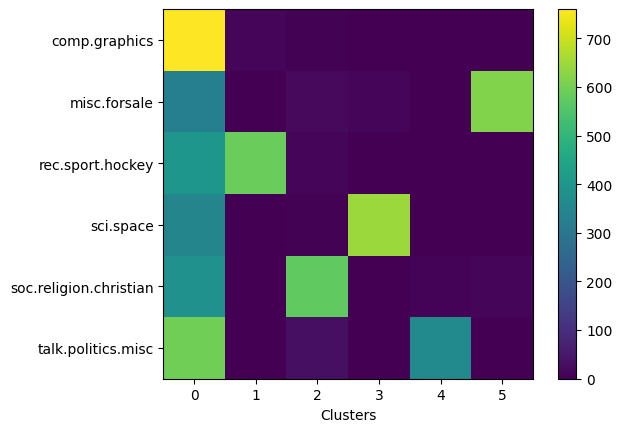

In [39]:
# We display a confusion matrix to observe the correspondance between the clusters and labels
confusion_matrix = np.zeros((6,6))
for sample_index in range(number_of_samples):
    x = int(km.labels_[sample_index])    
    y = int(label_to_cluster_index_mapping_kmeans_to_labels(df['label_indices'][sample_index]))
    confusion_matrix[y, x] += 1

plt.figure()
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xlabel('Clusters')
ax = plt.gca()
ax.set_yticks(np.arange(number_of_unique_labels), labels=unique_labels)
plt.show()

We verify with the figure above that KMeans clustering does a fair job at correctly identifying labels for `Clusters 1-5`. We also confirm that the topic of `talk.politics.misc` is the least well categorized because the `Cluster 0` is spread across all six labels.

## Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)

We apply a third unsupervised clustering approach to the dataset with UMAP.

In [40]:
n_components = 2
um = umap.UMAP(n_components=n_components, metric='cosine', n_neighbors=15, min_dist=0.01, spread=2, init='pca')

In [41]:
embeddings = um.fit_transform(vectors)

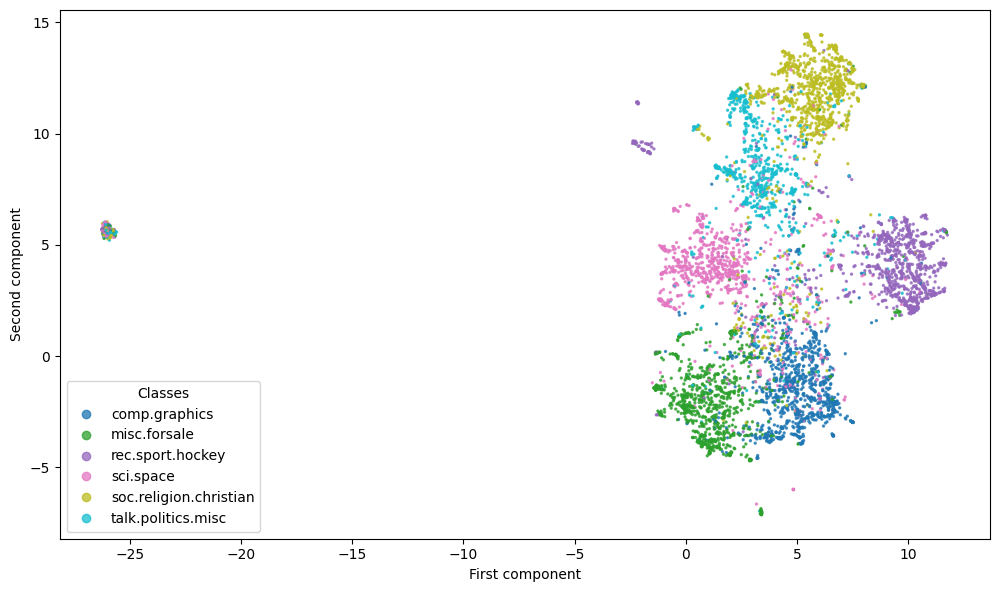

In [42]:
# Display the manifold embeddings
plt.figure(figsize=(12, 12))
scatter = plt.scatter(embeddings[:,0], embeddings[:,1], c=df['label_indices'], alpha=0.75, s=2, cmap='tab10')
plt.legend(scatter.legend_elements()[0], unique_labels, loc='lower left', title='Classes')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.show()

In the figure above, we observe that the six clusters are relatively well partitioned, using only two dimensions. We note some noisy overlap in between the different clusters, and a small group of outliers with points from all clusters, located far away from the main island.

## Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

We refine the UMAP results by applying a fourth unsupervised clustering approach with HDBSCAN. The purpose is to remove noisy points that cannot be clearly clustered.

In [43]:
hdbscan_labels = HDBSCAN(min_samples=65, min_cluster_size=170).fit_predict(embeddings)

In [44]:
# We implement another lookup table to make the indices of the clusters coincide between HDBSCAN and UMAP
def label_to_cluster_index_mapping_hdbscan_to_umap(label_indices):
    label_indices += 10
    label_indices[label_indices==10] = 2
    label_indices[label_indices==11] = 3
    label_indices[label_indices==12] = 5
    label_indices[label_indices==13] = 4
    label_indices[label_indices==14] = 0
    label_indices[label_indices==15] = 1
    return label_indices

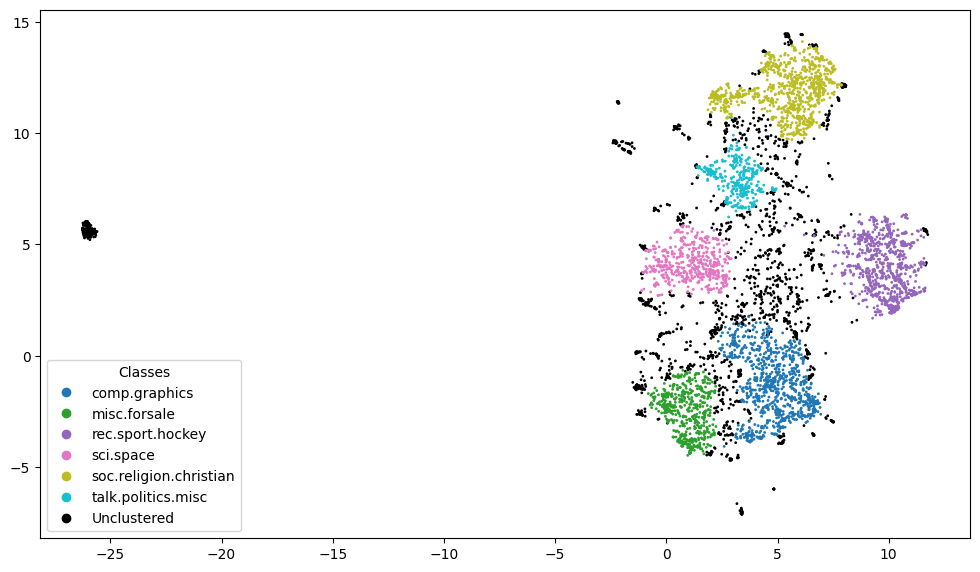

In [45]:
clustered = (hdbscan_labels >= 0)
plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.set_aspect('equal')

scatter_unclustered = ax.scatter(embeddings[~clustered, 0], embeddings[~clustered, 1], c=hdbscan_labels[~clustered], s=1, alpha=1, cmap='gist_gray')
scatter = ax.scatter(
    embeddings[clustered, 0], embeddings[clustered, 1],
    c=label_to_cluster_index_mapping_hdbscan_to_umap(hdbscan_labels[clustered]), s=1, cmap='tab10')
ax.legend(
    handles=[*scatter.legend_elements()[0], *scatter_unclustered.legend_elements()[0]],
    labels=[*unique_labels, 'Unclustered'], loc='lower left', title='Classes')
plt.show()